<a href="https://colab.research.google.com/github/Rasilu/cil/blob/main/code/Segformer_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning of the Segformer architecture
The segformer architecture is a transformer-based architecture, describe in this paper: https://proceedings.neurips.cc/paper/2021/file/64f1f27bf1b4ec22924fd0acb550c235-Paper.pdf

In this notebook we use the [huggingface](https://huggingface.co/) library for fine-tuning.

In [ ]:
!pip install transformers
!pip install datasets

In [8]:
import torch
import os
import json
import numpy as np
import cv2
import re
import time

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# huggingface imports
from datasets import load_dataset, load_metric
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation, SegformerConfig
from huggingface_hub import cached_download, hf_hub_url


### Helper functions

In [4]:
# some constants
PATCH_SIZE = 16  # pixels per side of square patches
VAL_SIZE = 10  # size of the validation set (number of images)
CUTOFF = 0.25  # minimum average brightness for a mask patch to be classified as containing road


In [5]:
# some helper functions

def np_to_tensor(x, device):
    # allocates tensors from np.arrays
    if device.type == 'cpu':
        return torch.from_numpy(x).cpu()
    else:
        return torch.from_numpy(x).contiguous().pin_memory().to(device=device, non_blocking=True)

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_all_from_path(path):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    return np.stack([np.array(Image.open(f)) for f in sorted(glob(path + '/*.png'))]).astype(np.float32) / 255.

def load_single_from_path(path):
    return np.stack([np.array(Image.open(f)) for f in sorted(glob(path + '/*.png'))]).astype(np.float32) / 255.

def image_to_patches(images, masks=None):
    # takes in a 4D np.array containing images and (optionally) a 4D np.array containing the segmentation masks
    # returns a 4D np.array with an ordered sequence of patches extracted from the image and (optionally) a np.array containing labels
    n_images = images.shape[0]  # number of images
    h, w = images.shape[1:3]  # shape of images
    assert (h % PATCH_SIZE) + (w % PATCH_SIZE) == 0  # make sure images can be patched exactly

    images = images[:,:,:,:3]
    
    h_patches = h // PATCH_SIZE
    w_patches = w // PATCH_SIZE
    
    patches = images.reshape((n_images, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE, -1))
    patches = np.moveaxis(patches, 2, 3)
    patches = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)
    if masks is None:
        return patches

    masks = masks.reshape((n_images, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE, -1))
    masks = np.moveaxis(masks, 2, 3)
    labels = np.mean(masks, (-1, -2, -3)) > CUTOFF  # compute labels
    labels = labels.reshape(-1).astype(np.float32)
    return patches, labels


def show_patched_image(patches, labels, h_patches=25, w_patches=25):
    # reorders a set of patches in their original 2D shape and visualizes them
    fig, axs = plt.subplots(h_patches, w_patches, figsize=(18.5, 18.5))
    for i, (p, l) in enumerate(zip(patches, labels)):
        # the np.maximum operation paints patches labeled as road red
        axs[i // w_patches, i % w_patches].imshow(np.maximum(p, np.array([l.item(), 0., 0.])))
        axs[i // w_patches, i % w_patches].set_axis_off()
    plt.show()


In [6]:

class ImageDataset(torch.utils.data.Dataset):
    # Dataset class that deals with loading the data and making it available by index.
    # This class is taken from the jupyter notebook of the tutorial session
    def __init__(self, path, feature_extractor, device, use_patches=True, resize_to=(400, 400)):
        self.path = path
        self.device = device
        self.use_patches = use_patches
        self.resize_to=resize_to
        self.x, self.y, self.n_samples = None, None, None
        self._load_data()

    def _load_data(self):  # not very scalable, but good enough for now
        self.x = load_all_from_path(os.path.join('data', self.path, 'images'))[:,:,:,:3]
        self.y = load_all_from_path(os.path.join('data', self.path, 'groundtruth'))
        if self.use_patches:  # split each image into patches
            self.x, self.y = image_to_patches(self.x, self.y)
        elif self.resize_to != (self.x.shape[1], self.x.shape[2]):  # resize images
            self.x = np.stack([cv2.resize(img, dsize=self.resize_to) for img in self.x], 0)
            self.y = np.stack([cv2.resize(mask, dsize=self.resize_to) for mask in self.y], 0)
        self.x = np.moveaxis(self.x, -1, 1)  # pytorch works with CHW format instead of HWC
        self.n_samples = len(self.x)

    def _preprocess(self, x, y):
        # to keep things simple we will not apply transformations to each sample,
        # but it would be a very good idea to look into preprocessing
        # TODO: apply some transformations
        return x, y

    def __getitem__(self, item):
        return self._preprocess(np_to_tensor(self.x[item], self.device), np_to_tensor(self.y[[item]], self.device))
    
    def __len__(self):
        return self.n_samples


In [7]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""
    # Taken from: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Fine_tune_SegFormer_on_custom_dataset.ipynb

    def __init__(self, root_dir, feature_extractor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train

        sub_path = "training" if self.train else "test"
        self.img_dir = os.path.join(self.root_dir, sub_path, "images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "groundtruth")

        #self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        #self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.img_dir, self.images[idx])).convert('RGB')
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = (np.array(segmentation_map) == 255).astype(int)

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k, v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs


# Data loading

In [ ]:
start_download_data = time.time()

!git clone https://github.com/Rasilu/cil

stop_download_data = time.time()
print(f"Time to load data: {round(stop_download_data - start_download_data, 2)}")

# Training

In [ ]:
feature_extractor = SegformerFeatureExtractor(reduce_labels=False)

device = get_device()

# load the data
root_dir = os.path.join('cil', 'datasets', 'kaggle_augmented') # adapt this line of code to use different datasets

# set image_mean & image_std to None if no preprocessing should be applied
# feature_extractor = SegformerFeatureExtractor(reduce_labels=False, size=400, image_mean=dataset_mean, image_std=dataset_std)
feature_extractor = SegformerFeatureExtractor(reduce_labels=False, size=400)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, train=False)
encoded_inputs = train_dataset[0]

print(f"shape of pixel_values: {encoded_inputs['pixel_values'].shape}")
print(f"shape of labels: {encoded_inputs['labels'].shape}")

print(f"labels: {encoded_inputs['labels']}")

print(f"Unique labels: {encoded_inputs['labels'].squeeze().unique()}")

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8)


# id2label mapping
id2label = {0: "is_road", 1: "is_not_road"}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b3",
                                                          num_labels=2,
                                                          id2label=id2label,
                                                          label2id=label2id)

metric = load_metric("mean_iou")
# fine-tuning

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
model.to(device)

model.train()

history = {}  # collects metrics at the end of each epoch
n_epochs = 10

n_accumulation_steps = 1 # accumulating gradients, together with a batch size of m we update the gradients every n*m samples

optimizer.zero_grad()

for epoch in range(n_epochs):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
  
        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss = loss / n_accumulation_steps
        loss.backward()

        if idx % n_accumulation_steps == 0: # this is for the accumulating gradients
          optimizer.step()
          # zero the parameter gradients
          optimizer.zero_grad()
          # evaluate
          with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
            
            # note that the metric expects predictions + labels as numpy arrays
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())


        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          metrics = metric.compute(num_labels=len(id2label), 
                                   ignore_index=None,
                                   reduce_labels=False
          )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

# save the fine-tuned model

model_dir = "fine_tuned_segformer"
if not os.path.isdir("fine_tuned_segformer"):
  os.makedirs(model_dir)
model.save_pretrained(model_dir)

# Inference

In [ ]:
img_path = os.path.join('drive', 'MyDrive', 'ETH', 'CIL', 'Project', 'datasets', 'kaggle_data', 'test', 'images', 'satimage_145.png')

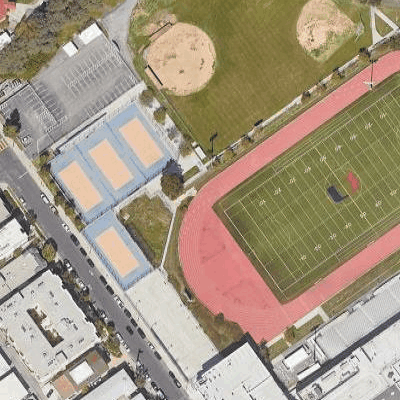

In [ ]:
image = Image.open(img_path).convert('RGB')
image

SemanticSegmenterOutput(loss=None, logits=tensor([[[[ 1.9881,  2.4102,  2.4575,  ...,  0.5565,  0.4177,  0.2520],
          [ 2.2749,  2.2818,  2.0792,  ...,  0.6948,  0.4615,  0.3071],
          [ 2.4401,  2.5214,  2.2988,  ...,  1.2336,  0.8660,  0.7371],
          ...,
          [ 4.5481,  4.2690,  4.1398,  ...,  0.8322,  0.9528,  0.9104],
          [ 4.7619,  4.5668,  4.7020,  ...,  0.5105,  0.2778, -0.2151],
          [ 4.7783,  4.8710,  4.6268,  ..., -0.2720, -0.6029, -0.9867]],

         [[-0.7707, -1.7467, -1.3884,  ...,  0.3191,  0.6558,  0.6459],
          [-1.3281, -1.0615, -1.1991,  ...,  0.2621,  0.2868,  0.4467],
          [-1.9406, -1.7340, -1.4481,  ..., -0.7628, -0.3367, -0.1991],
          ...,
          [-4.3905, -4.1842, -4.1532,  ..., -0.1624,  0.0926,  0.0289],
          [-4.5043, -4.6634, -4.1541,  ...,  0.2713,  0.8559,  1.2565],
          [-4.6991, -4.4892, -4.3122,  ...,  0.8847,  1.3661,  1.7283]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>), hi

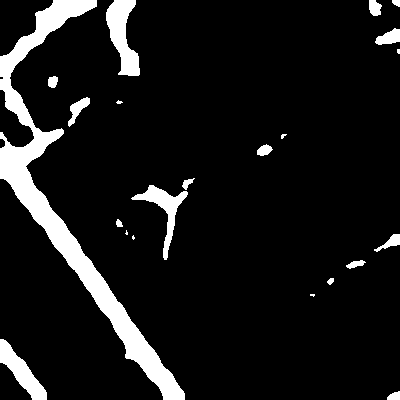

In [ ]:
from google.colab.patches import cv2_imshow

encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)

# forward pass
outputs = model(pixel_values=pixel_values)
print(outputs)
logits = outputs.logits.cpu()
# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)
seg = upsampled_logits.argmax(dim=1)[0]
print(seg)
cv2_imshow(seg.cpu().numpy()*255)

In [ ]:
import os
import numpy as np
import matplotlib.image as mpimg
import PIL


base_dir = os.path.join('drive', 'MyDrive', 'ETH', 'CIL', 'Project', 'datasets', 'kaggle_data', 'test', 'images')
submission_filename = f"segformer_additional_{n_epochs}epochs.csv"

foreground_threshold = 0.25 # percentage of pixels of val 255 required to assign a foreground label to a patch

def load_all_from_path(path):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    # return np.stack([np.array(Image.open(f)) for f in sorted(glob(path + '/*.png'))]).astype(np.float32) / 255.
    return np.array([np.array(Image.open(f).convert('RGB')) for f in sorted(glob(path + '/*.png'))]).astype(np.float32) / 255.


# assign a label to a patch
def patch_to_label(patch):
    patch = patch.astype(np.float64) / 255
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename, mask_dir=None):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = PIL.Image.open(image_filename)
    im_arr = np.asarray(im)
    if len(im_arr.shape) > 2:
        # Convert to grayscale.
        im = im.convert("L")
        im_arr = np.asarray(im)

    patch_size = 16
    mask = np.zeros_like(im_arr)
    for j in range(0, im_arr.shape[1], patch_size):
        for i in range(0, im_arr.shape[0], patch_size):
            patch = im_arr[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            mask[i:i+patch_size, j:j+patch_size] = int(label*255)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))

    if mask_dir:
        save_mask_as_img(mask, os.path.join(mask_dir, "mask_" + image_filename.split("/")[-1]))
    

def save_mask_as_img(img_arr, mask_filename):
    img = PIL.Image.fromarray(img_arr)
    os.makedirs(os.path.dirname(mask_filename), exist_ok=True)
    img.save(mask_filename)


def masks_to_submission(submission_filename, mask_dir, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn, mask_dir=mask_dir))


image_filenames = [os.path.join(base_dir, name) for name in os.listdir(base_dir)]
test_images = load_all_from_path(base_dir)

test_preds = []

for i, t in enumerate(test_images):
  encoding = feature_extractor(t, return_tensors="pt")
  pixel_values = encoding.pixel_values.to(device)

  # forward pass
  outputs = model(pixel_values=pixel_values)
  logits = outputs.logits.cpu()
  # First, rescale logits to original image size
  upsampled_logits = nn.functional.interpolate(logits,
                  size=image.size[::-1], # (height, width)
                  mode='bilinear',
                  align_corners=False)
  seg = upsampled_logits.argmax(dim=1)[0].numpy()
  test_preds.append(seg)
test_preds = np.array(test_preds)

In [ ]:
print(test_preds.shape)

(144, 400, 400)


In [ ]:
def create_submission(labels, test_filenames, submission_filename):
    test_path='test/images'
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn, patch_array in zip(sorted(test_filenames), test_preds):
            img_number = int(re.search(r"\d+", fn).group(0))
            for i in range(patch_array.shape[0]):
                for j in range(patch_array.shape[1]):
                    f.write("{:03d}_{}_{},{}\n".format(img_number, j*PATCH_SIZE, i*PATCH_SIZE, int(patch_array[i, j])))

size = test_images.shape[1:3]
print(f"size: {size}")
print(test_images.shape)
test_preds = test_preds.reshape((-1, size[0] // PATCH_SIZE, PATCH_SIZE, size[0] // PATCH_SIZE, PATCH_SIZE))
test_preds = np.moveaxis(test_preds, 2, 3)
test_preds = np.round(np.mean(test_preds, (-1, -2)) > CUTOFF)
print(test_preds.shape)
create_submission(test_preds, image_filenames, submission_filename=f"segformer_augmented_{n_epochs}epochs.csv")

size: (400, 400)
(144, 400, 400, 3)
(144, 25, 25)


In [ ]:
!ls -l

total 1188
drwx------ 5 root root    4096 Jul 20 10:37 drive
drwxr-xr-x 2 root root    4096 Jul 20 13:14 fine_tuned_segformer
drwxr-xr-x 1 root root    4096 Jul 13 13:43 sample_data
-rw-r--r-- 1 root root 1202414 Jul 20 13:15 segformer_augmented_15epochs.csv
